In [1]:
''' In this project, I will be using machine learning to create a regression model that will the price of a uber ride based on parameters such as 
    pick up time, the pick up and drop off location, datetime, and passenger count. I will be using the XGBoost to build the regression model.
    I obtained this dataset on Kaggle (https://www.kaggle.com/datasets/yasserh/uber-fares-dataset)
'''

# We first import the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost


In [2]:
# Now, we import our dataset into a Pandas dataframe

df = pd.read_csv('/content/uber.csv')

In [3]:
# We look for general information about our data. We see that we have some object data types which we will deal with. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
# First, we convert the pickup_datetime to the datetime datatype

df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [5]:
# Now, we drop duplicates rows 

df.drop_duplicates()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1


In [6]:
# We extract the hour, day and month from the datetime column

df['hour'] = df.pickup_datetime.dt.hour
df['day'] = df.pickup_datetime.dt.day
df['month'] = df.pickup_datetime.dt.month

In [7]:
# Now that we have the hour, we encode this column with the cos and sin function to preserve the cyclical nature of hour.

df['sin_hour'] = np.sin(2*np.pi*df.hour/24)
df['cos_hour'] = np.cos(2*np.pi*df.hour/24)

In [8]:
# Similarly, we perform cos and sin encoding for our day and month

df['sin_day'] = np.sin(2*np.pi*df.hour/30)
df['cos_day'] = np.cos(2*np.pi*df.hour/30)

df['sin_month'] = np.sin(2*np.pi*df.hour/12)
df['cos_month'] = np.cos(2*np.pi*df.hour/12)

In [9]:
# Now that we have the cos and sin encodings we can drop the following columns: 
# Unnamed 0, key, pickup_datetime, hour, day, and month

df = df.drop(['Unnamed: 0', 'key', 'pickup_datetime', 'hour', 'day', 'month'], axis=1)

# We also drop the one row that has an empty entry

df = df.dropna()
df.reset_index(drop=True)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,-0.965926,0.258819,-0.743145,-0.669131,-0.500000,-8.660254e-01
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,-0.866025,0.500000,-0.866025,-0.500000,-0.866025,-5.000000e-01
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,-0.707107,0.707107,-0.951057,-0.309017,-1.000000,-4.286264e-16
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,0.866025,-0.500000,0.994522,-0.104528,-0.866025,-5.000000e-01
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,-0.965926,-0.258819,-0.406737,-0.913545,0.500000,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
199994,3.0,-73.987042,40.739367,-73.986525,40.740297,1,0.500000,-0.866025,0.866025,-0.500000,-0.866025,5.000000e-01
199995,7.5,-73.984722,40.736837,-74.006672,40.739620,1,0.258819,0.965926,0.207912,0.978148,0.500000,8.660254e-01
199996,30.9,-73.986017,40.756487,-73.858957,40.692588,2,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00
199997,14.5,-73.997124,40.725452,-73.983215,40.695415,1,-0.500000,-0.866025,0.207912,-0.978148,0.866025,5.000000e-01


<Axes: >

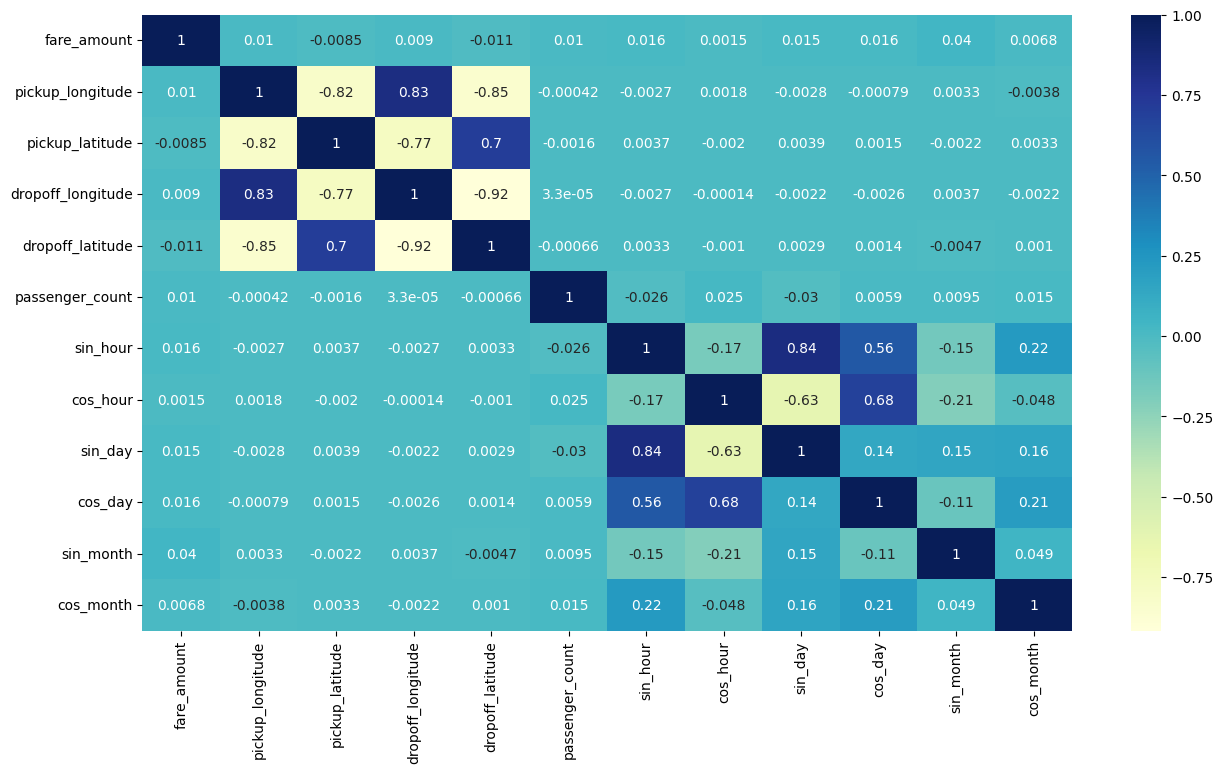

In [10]:
# Now that we have dealt with our data, we can start doing some further exploration.
# We will create a heatmap to see the correlation between the features.

plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

In [11]:
# We see that while there are strong correlations between the pickup and dropoff features, we cannot drop these columns since the distance travelled in a ride 
# should strongly determine the fare amount.

(-75.0, -73.0)

<Figure size 2000x1000 with 0 Axes>

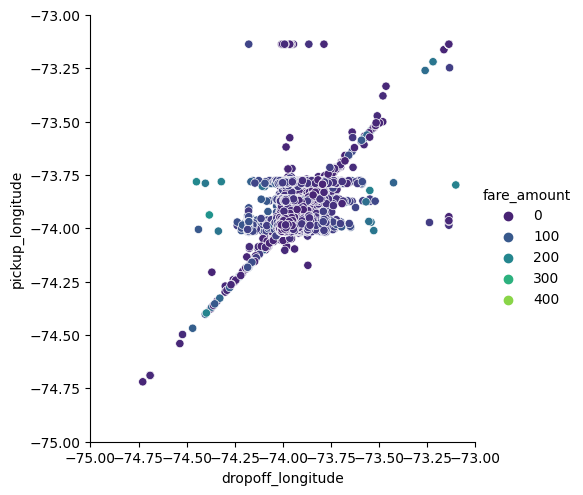

In [12]:
# To further visualize the relationship between pickup_longitude and dropoff_longitude, let's create a scatterplot 
plt.figure(figsize=(20,10))
sns.relplot(x='dropoff_longitude', y='pickup_longitude', hue='fare_amount', data=df, palette='viridis')
plt.xlim(-75,-73)
plt.ylim(-75,-73)

In [13]:
# Now that we have explored, cleaned and visualized our data, we are ready to build our model
# But first, we need to create our training and testing sets

X = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']

# Since we have around 200,000 samples, a cross-validation set with 4000 samples is sufficient

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, random_state=42)

In [14]:
# Now we scale our data so that our model can train more efficiently during gradient descent.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [15]:
# Now we are ready to build our model. We will be using XGBoost regression.

import xgboost

regressor = xgboost.XGBRegressor()

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
# We will compute the accuracy of our model

y_pred = regressor.predict(X_val)
from sklearn.metrics import r2_score
score = r2_score(y_val, y_pred)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

The accuracy of our model is 75.0%


In [17]:
# Great! We have achieved an accuracy of 75% which is a solid and realistic percentage for a regression model

<BarContainer object of 11 artists>

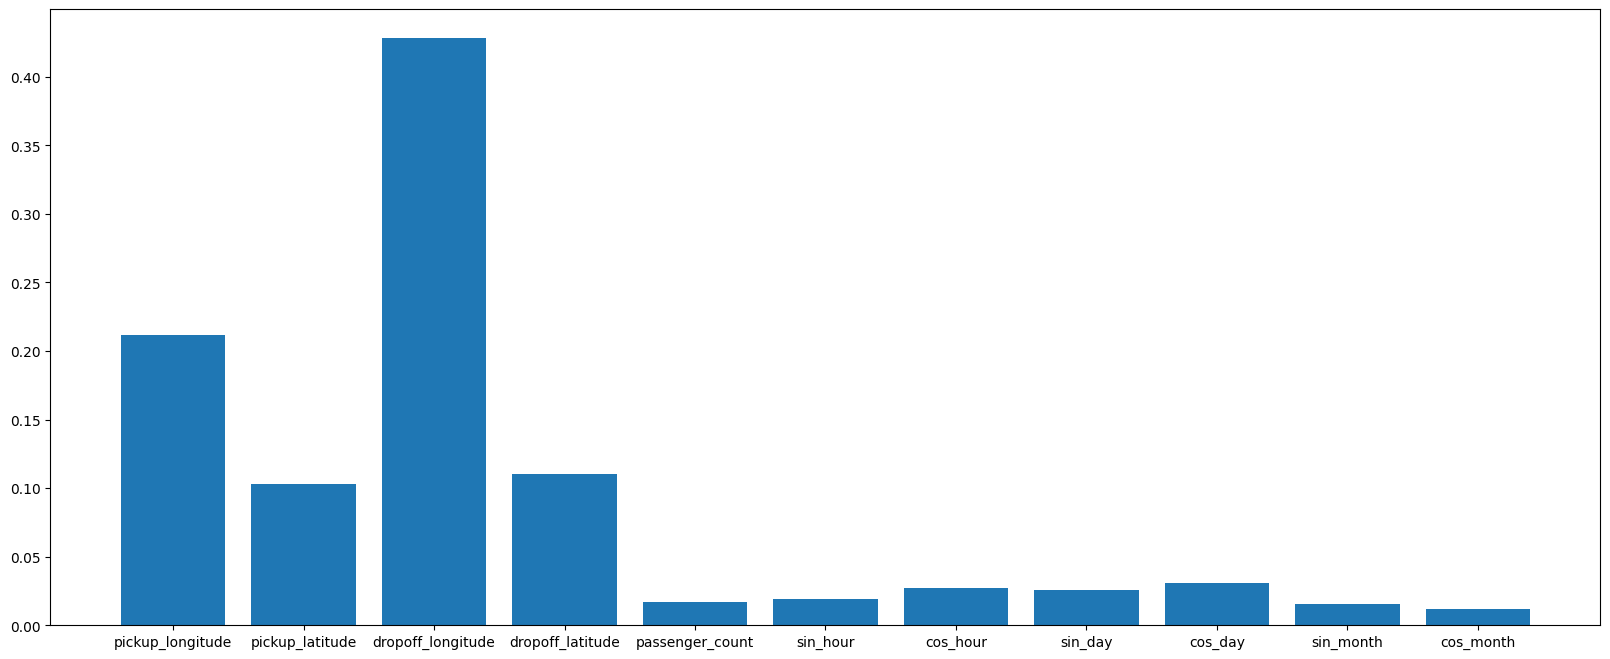

In [18]:
# Finally, we will take advantage of XGboost feature importance function to verify our claim that
# the pick up and dropoff features are the most significant features in the model
plt.figure(figsize=(20,8))
plt.bar(X.columns, regressor.feature_importances_)
